# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [1]:
import pandas as pd
data = pd.read_csv('./Unit_5_data/Advertising.csv',index_col=0)
data.head(2)

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [2]:
print (f'Количество пропусков в данных {data.isna().sum().sum()}')

Количество пропусков в данных 0


**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [3]:
X, y = data[['TV','radio','newspaper']].values, data.sales.values

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [4]:
import numpy as np
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [5]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [6]:
predictors_num = X.shape[1]
w_cd = np.zeros(predictors_num)
     
for _ in range(1000):        
    r = y - X@w_cd   
    for i in range(predictors_num):     
        r = r + X[:, i]*w_cd[i]
        w_cd[i] = X[:, i]@r
        r = r -  X[:, i]*w_cd[i]
for i,w_i in enumerate(w_cd):  print(f'w{i}:{w_i}', end = "   ")
# получим прогноз координатного спуска, нам он понадобится позже   
pred_cd =  X@w_cd

w0:41.562172046036125   w1:110.13144155326066   w2:73.52860637603473   w3:-0.5500638414306833   

Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [7]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Если вы все сделали верно, они должны практически совпасть!

Сравнение полученных результатов показывает, что различие    
в коэффициентах составляет крайне малые величины порядка $10^{-14}$

In [8]:
w_cd - model.coef_

array([-1.20792265e-13,  4.26325641e-14,  1.42108547e-14,  1.57651669e-14])

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [9]:
X, y = data[['TV','radio','newspaper']].values, data.sales.values
X = (X - X.mean(axis=0))/X.std(axis=0)

**Добавим единичный столбец**

In [10]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [11]:
# определим mse_error
def mse_error(y_true,y_pred):
    return ((y_true - y_pred)**2).mean()
# так же определим mae_error, которая нам понадобится в задании позже
def mae_error(y_true,y_pred):
    return abs(y_true - y_pred).mean()

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [12]:
pred_naive = np.full(y.shape,fill_value = y.mean())
mse_error(y,pred_naive)

27.085743750000002

**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [13]:
def lin_pred(X,w):
    return X@w

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [14]:
def stoch_grad_step(X,y,w,train_ind,eta):
    observation = X[[train_ind],:]
    resid = (lin_pred(observation,w)-y[train_ind])
    w_next = w - eta*(observation.T@resid)
    return w_next

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [15]:
def stochastic_gradient_descent(X,y,w,learning_rate,max_iter,epsilon = 10**-15):
    distance = np.inf # иниилизаия расстояния между векторами весов
    err = []          # вектора ошибок
    iter_count = 0    # счетчика итераий
                        
    while iter_count < max_iter and distance > epsilon:
        train_ind = np.random.randint(len(y))
        w_current = stoch_grad_step(X, y, w, train_ind, learning_rate)
        err_current = mse_error(y,lin_pred(X,w_current))
        err.append(err_current)
        distance = np.linalg.norm(w-w_current)
        w = w_current
        iter_count += 1
    return w,err

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**Постройте график зависимости ошибки от номера итерации**

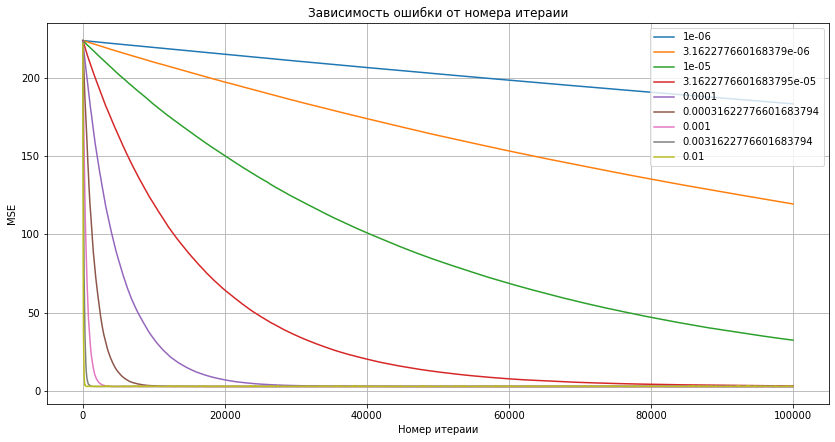

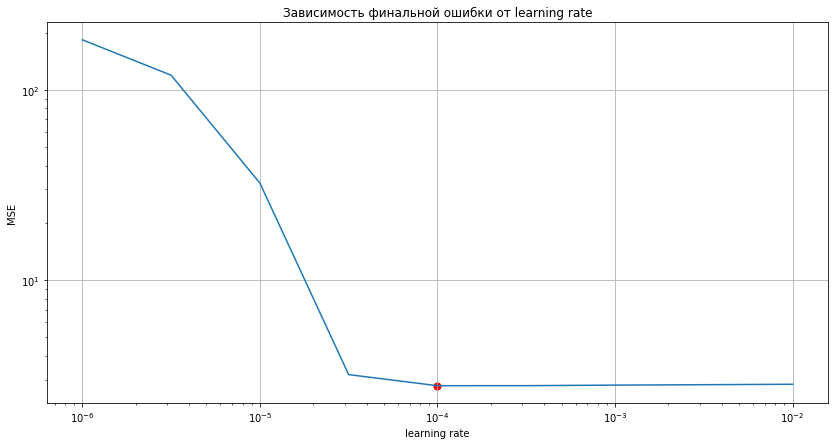

In [16]:
import matplotlib.pyplot as plt

# реализуем SGD для ряда величин learning rate 
max_iter = 10**5
learning_rates = np.logspace(-6,-2,num =9)
result, errors = [], []

for learn_rt in learning_rates:
    w = np.zeros(X.shape[1])
    result.append(stochastic_gradient_descent(X,y,w,learn_rt,max_iter)[0])
    errors.append(stochastic_gradient_descent(X,y,w,learn_rt,max_iter)[1])

# посторим графикизависимости ошибок у несколкьих реализаий SGD от номера итерации
step = 10

plt.figure(figsize=(14,7))
plt.grid(True)
plt.title('Зависимость ошибки от номера итераии')
plt.ylabel('MSE')
plt.xlabel("Номер итераии")

for errs in errors:
    plt.plot (list(range(0,len(errs),step)),errs[::step])
    
plt.legend(learning_rates.astype(str),loc='upper right')
plt.show()
# построим график зависимости итоговой ошибки от learning rate и обозначим точку минмума ошибки
fin_errs = pd.Series([x[-1] for x in errors],learning_rates)

plt.figure(figsize=(14,7))
plt.grid(True)
plt.title('Зависимость финальной ошибки от learning rate')
plt.ylabel('MSE')
plt.xlabel("learning rate")
plt.yscale('log')
plt.xscale('log')
plt.plot (fin_errs)
plt.scatter(fin_errs.idxmin(),fin_errs.min(),s=50,c='red')
plt.show()

Первый график показывает впрлне ожидаемую картину - скорость обучения прямо пропорианальна величине *learning rate* (слишком большие значения, приводящие к расхождению в наш диапазон не попали)

Второй график демонстрирует, что с момента, когда *learning rate* позволяет успеть алгоритму сойтись за отведенное количесвто итераий, итоговая ошибка меняется крайне незначительно, но минимум все же существует. Этот минимум итоговой ошибки работы алгоритма при *learning rate* = $10^{-4}$. В качестве итога примем результат при этом значении. 

In [17]:
fin_index = np.where(learning_rates== 10**-4)[0][0]

**Выведите вектор весов, к которому сошелся метод.**

In [18]:
w_sgd = result[fin_index]
w_sgd

array([14.01273248,  3.91121351,  2.78347286, -0.03759328])

**Выведите среднеквадратичную ошибку на последней итерации.**

In [19]:
errors[fin_index][-1]

2.7842941342630563

В конце работы, как нас и просили в задании, оценим качество обеих полученных моделей (SGD и координатный спуск) с помощью MSE и MAE, так же в качестве base-line рассмотрим наивный прогноз

In [20]:
pred_sgd =  X@w_sgd

dt = [[mse_error(y,pred_sgd),mae_error(y,pred_sgd)],
      [mse_error(y,pred_cd),mae_error(y,pred_cd)],
      [mse_error(y,pred_naive),mae_error(y,pred_naive)]]
pd.DataFrame(dt,index = ['SGD','Координатный спуск','Наивный прогноз'],columns=['MSE','MAE'])

,MSE,MAE
SGD,2.784700,1.253320
Координатный спуск,2.784126,1.252011
Наивный прогноз,27.085744,4.279975


Как видим результаты работы обеих алгоритмов близки. На предоставленных данных существенная разница не наблюдается - ни по точности, ни поскорости схождения(если в SGD брать большие learning rate). При этом оба алгоритма значительно выиигрывают у простого среднего.